# Alternative Second Term Project: ARQMath Collection, Answer Retrieval Task

“In a recent study, Mansouri et al. found that 20% of mathematical queries in a general-purpose search engine were expressed as well-formed questions, a rate ten times higher than that for all queries submitted. Results such as these and the presence of Community Question Answering sites such as Math Stack Exchange suggest there is interest in finding answers to mathematical questions posed in natural language, using both text and mathematical notation.” [1]

“[ARQMath](https://www.cs.rit.edu/~dprl/ARQMath/) is a co-operative evaluation exercise aiming to advance math-aware search and the semantic analysis of mathematical notation and texts. **ARQMath is being run for the second time at CLEF 2021.** An overview paper (including results) from ARQMath 2020 is available along with participant papers in the [CLEF 2020 working notes](http://ceur-ws.org/Vol-2696).” [2]

 ![Answer Retrieval Task](https://www.cs.rit.edu/~dprl/ARQMath/assets/images/screen-shot-2019-09-09-at-11.11.57-pm-2656x1229.png)

Your tasks, reviewed by your colleagues and the course instructors, are the following:

1.   *Implement a supervised ranked retrieval system*, [3, Chapter 15] which will produce a list of documents from the TREC collection in a descending order of relevance to a query from the TREC collection. You SHOULD use training and validation relevance judgements from the TREC collection in your information retrieval system. Test judgements MUST only be used for the evaluation of your information retrieval system.

2.   *Document your code* in accordance with [PEP 257](https://www.python.org/dev/peps/pep-0257/), ideally using [the NumPy style guide](https://numpydoc.readthedocs.io/en/latest/format.html#docstring-standard) as seen in the code from exercises.  
     *Stick to a consistent coding style* in accordance with [PEP 8](https://www.python.org/dev/peps/pep-0008/).

3.   *Reach at least 1.2% mean average precision* [3, Section 8.4] with your system on the Trec collection. You are encouraged to use techniques for tokenization, [3, Section 2.2] document representation [3, Section 6.4], tolerant retrieval [3, Chapter 3], relevance feedback, query expansion, [3, Chapter 9], learning to rank [3, Chapter 15], and others discussed in the course.

4.   _[Upload an .ipynb file](https://is.muni.cz/help/komunikace/spravcesouboru#k_ss_1) with this Jupyter notebook to the homework vault in IS MU._ You MAY also include a brief description of your information retrieval system and a link to an external service such as [Google Colaboratory](https://colab.research.google.com/), [DeepNote](https://deepnote.com/), or [JupyterHub](https://iirhub.cloud.e-infra.cz/).

The best student systems will enter the ARQMath competition and help develop the new search engine for [the Math StackExchange question answering forum](http://math.stackexchange.com/). This is not only useful, but also a nice reference for your CVs!

[1] Zanibbi, R. et al. [Overview of ARQMath 2020 (Updated Working Notes Version): CLEF Lab on Answer Retrieval for Questions on Math](http://ceur-ws.org/Vol-2696/paper_271.pdf). In: *Working Notes of CLEF 2020-Conference and Labs of the Evaluation Forum*. 2020.

[2] Zanibbi, R. et al. [*ARQMath: Answer Retrieval for Questions on Math*](https://www.cs.rit.edu/~dprl/ARQMath/index.html). Rochester Institute of Technology. 2021.

[3] Manning, Christopher D., Prabhakar Raghavan, and Hinrich Schütze. [*Introduction to information retrieval*](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf). Cambridge university press, 2008.

## Loading the ARQMath collection

First, we will install [our library](https://gitlab.fi.muni.cz/xstefan3/pv211-utils) and load the ARQMath collection. If you are interested, you can take a peek at [how we preprocessed the raw ARQMath collection](https://colab.research.google.com/drive/1WiLLDIBaOteLevNdxVonQrYSW919ckwO) to the final dataset that we will be using.

In [ ]:
%%capture
! pip install git+https://github.com/MIR-MU/pv211-utils.git
! pip install gensim==3.6.0

The questions and answers from the ARQMath collection, and the queries from the from the answer retrieval task of ARQMath 2020 contain both text and mathematical formulae. We have prepared several encodings of the text and mathematical, which you can choose from:

- `text` – Plain text, which contains no mathematical formulae. *Nice and easy*, but you are losing all information about the math:

    > Finding value of  such that ...

- `text+latex` – Plain text with mathematical formulae in LaTeX surrounded by dollar signs. Still quite nice to work:

    > Finding value of \$c\$ such that ...

- `text+tangentl` – Plain text with mathematical formulae in [the mathtuples format][5] of [the Tangent-L system][6]. Like LaTeX, the mathtuples format encodes how a mathematical formula looks, but is fuzzier in order to improve recall.

    > Finding value of #(start)# #(v!c,!0,-)# #(v!c,!0)# #(end)# such that ...

- `text+prefix` – Plain text with mathematical formulae in [the prefix format][1]. Unlike LaTeX, which encodes how a mathematical formula looks, the prefix format encodes the semantic content of the formulae using [the Polish notation][2].

    > Finding value of V!𝑐 such that ...

- `xhtml+latex` – XHTML text with mathematical formulae in LaTeX, surrounded by the `<span class="math-container">` tags:

    > ``` html
    > <p>Finding value of <span class="math-container">$c$</span> such that ...
    > ```

- `xhtml+pmml` – XHTML text with mathematical formulae in the [Presentation MathML][4] XML format, which encodes how a mathematical formula looks:

    > ``` html
    > <p>Finding value of <math><mi>c</mi></math> such that'
    > ```

- `xhtml+cmml` – XHTML text with mathematical formulae in the [Content MathML][3] XML format, which encodes the semantic content of a formula. This format is *much more difficult to work with*, but it allows you to represent mathematical formulae structurally and use XML Retrieval [3, Chapter 10].

    > ``` html
    > <p>Finding value of <math><ci>𝑐</ci></math> such that ...
    > ```

 [1]: http://ceur-ws.org/Vol-2696/paper_235.pdf#page=5
 [2]: https://en.wikipedia.org/wiki/Polish_notation
 [3]: https://www.w3.org/TR/MathML2/chapter4.html
 [4]: https://www.w3.org/TR/MathML2/chapter3.html
 [5]: https://github.com/fwtompa/mathtuples
 [6]: http://ceur-ws.org/Vol-2936/paper-05.pdf#page=3

In [ ]:
text_format = 'text'

### Loading the answers

Next, we will define a class named `Answer` that will represent a preprocessed answer from the ARQMath 2020 collection. Tokenization and preprocessing of the `body` attribute of the individual answers as well as the creative use of the `upvotes` and `is_accepted` attributes is left to your imagination and craftsmanship.

In [ ]:
from pv211_utils.arqmath.entities import ArqmathAnswerBase

class Answer(ArqmathAnswerBase):
    """A preprocessed answer from the ARQMath 2020 collection.

    Parameters
    ----------
    document_id : str
        A unique identifier of the answer among all questions and answers.
    body : str
        The text of the answer, including mathematical formulae.
    upvotes : int
        The number of upvotes for the answer.
    is_accepted : bool
        If the answer has been accepted by the poster of the question.

    """
    def __init__(self, document_id: str, body: str, upvotes: int,
                 is_accepted: bool):
        # preprocessing?
        super().__init__(document_id, body, upvotes, is_accepted)

We will load answers into the `answers` [ordered dictionary](https://docs.python.org/3.8/library/collections.html#collections.OrderedDict). Each answer is an instance of the `Answer` class that we have just defined.

In [ ]:
from pv211_utils.arqmath.loader import load_answers

answers = load_answers(text_format, Answer,
                       cache_download=f'/var/tmp/pv211/arqmath2020_answers_{text_format}.json.gz')

In [ ]:
print('\n'.join(repr(answer) for answer in list(answers.values())[:3]))
print('...')
print('\n'.join(repr(answer) for answer in list(answers.values())[-3:]))

For a demonstration, we will load [the accepted answer from the image above][1].

 [1]: https://math.stackexchange.com/a/30741

In [ ]:
answer = answers['30741']
answer

In [ ]:
print(answer.body)

In [ ]:
print(answer.upvotes)

In [ ]:
print(answer.is_accepted)

### Loading the questions

Next, we will define a class named `Question` that will represent a preprocessed question from the ARQMath 2020 collection. Tokenization and preprocessing of the `title` and `body` attributes of the individual questions as well as the creative use of the `tags`, `upvotes`, `views`, and `answers` attributes is left to your imagination and craftsmanship.

We will not be returning these questions from our search engine, but we could use them for example to look up similar existing questions to a query and then return the answers to these existing questions.

In [ ]:
from typing import List

from pv211_utils.arqmath.entities import ArqmathQuestionBase

class Question(ArqmathQuestionBase):
    """A preprocessed question from the ARQMath 2020 collection.

    Parameters
    ----------
    document_id : str
        A unique identifier of the question among all questions and answers.
    title : str
        The title of the question, including mathematical formulae.
    body : str
        The text of the question, including mathematical formulae.
    tags : list of str
        Tags describing the topics of the question.
    upvotes : int
        The number of upvotes for the question.
    views : int
        The number of views for the question.
    answers : list of Answer
        The answers for the question.

    """
    def __init__(self, document_id: str, title: str, body: str, tags: List[str],
                 upvotes: int, views: int, answers: List[Answer]):
        # preprocessing?!
        super().__init__(document_id, title, body, tags, upvotes, views, answers)

We will load answers into the `questions` [ordered dictionary](https://docs.python.org/3.8/library/collections.html#collections.OrderedDict). Each answer is an instance of the `Question` class that we have just defined.

In [ ]:
from pv211_utils.arqmath.loader import load_questions

questions = load_questions(text_format, answers, Question,
                           cache_download=f'/var/tmp/pv211/arqmath2020_questions_{text_format}.json.gz')

answer_to_question = {
    answer: question
    for question in questions.values()
    for answer in question.answers
}

In [ ]:
print('\n'.join(repr(question) for question in list(questions.values())[:3]))
print('...')
print('\n'.join(repr(question) for question in list(questions.values())[-3:]))

For a demonstration, we will load [the question from the image above][1].

 [1]: https://math.stackexchange.com/q/30732

In [ ]:
question = questions['30732']
question

In [ ]:
print(question.title)

In [ ]:
print(question.body)

In [ ]:
print(question.tags)

In [ ]:
print(question.upvotes)

In [ ]:
print(question.views)

In [ ]:
print(question.answers)

In [ ]:
print([answer for answer in question.answers if answer.is_accepted])

### Loading the queries
Next, we will define a class named `Query` that will represent a preprocessed query from the answer retrieval task of ARQMath 2020. Tokenization and preprocessing of the `title` and `body` attributes of the individual questions as well as the creative use of the `tags` attribute is left to your imagination and craftsmanship.

In [ ]:
from pv211_utils.arqmath.entities import ArqmathQueryBase

class Query(ArqmathQueryBase):
    """A preprocessed query from the answer retrieval task of ARQMath 2020.

    Parameters
    ----------
    query_id : int
        A unique identifier of the query.
    title : str
        The title of the query, including mathematical formulae.
    body : str
        The text of the query, including mathematical formulae.
    tags : list of str
        Tags describing the topics of the query.

    """
    def __init__(self, query_id: int, title: str, body: str, tags: List[str]):
        # preprocessing!
        super().__init__(query_id, title, body, tags)

We will load queries into the `train_queries` and `validation_queries` [ordered dictionaries](https://docs.python.org/3.8/library/collections.html#collections.OrderedDict). Each query is an instance of the `Query` class that we have just defined. You should use `train_queries`, `validation_queries`, and *relevance judgements* (see the next section) for training your supervised information retrieval system.

If you are training just a single machine learning model without any early stopping or hyperparameter optimization, you can use `bigger_train_queries` as the input.

If you are training a single machine learning model with early stopping or hyperparameter optimization, you can use `train_queries` for training your model and `validation_queries` to stop early or to select the optimal hyperparameters for your model. You can then use `bigger_train_queries` to train the model with the best number of epochs or the best hyperparameters.

If you are training many machine learning models with early stopping or hyperparameter optimization, then you can split your train judgements to smaller training and validation sets. Then, you can use `smaller_train_queries` for training your models, `smaller_validation_queries` to stop early or to select the optimal hyperparameters for your models, and `validation_queries` to select the best model. You can then use `bigger_train_queries` to train the best model with the best number of epochs or the best hyperparameters.


 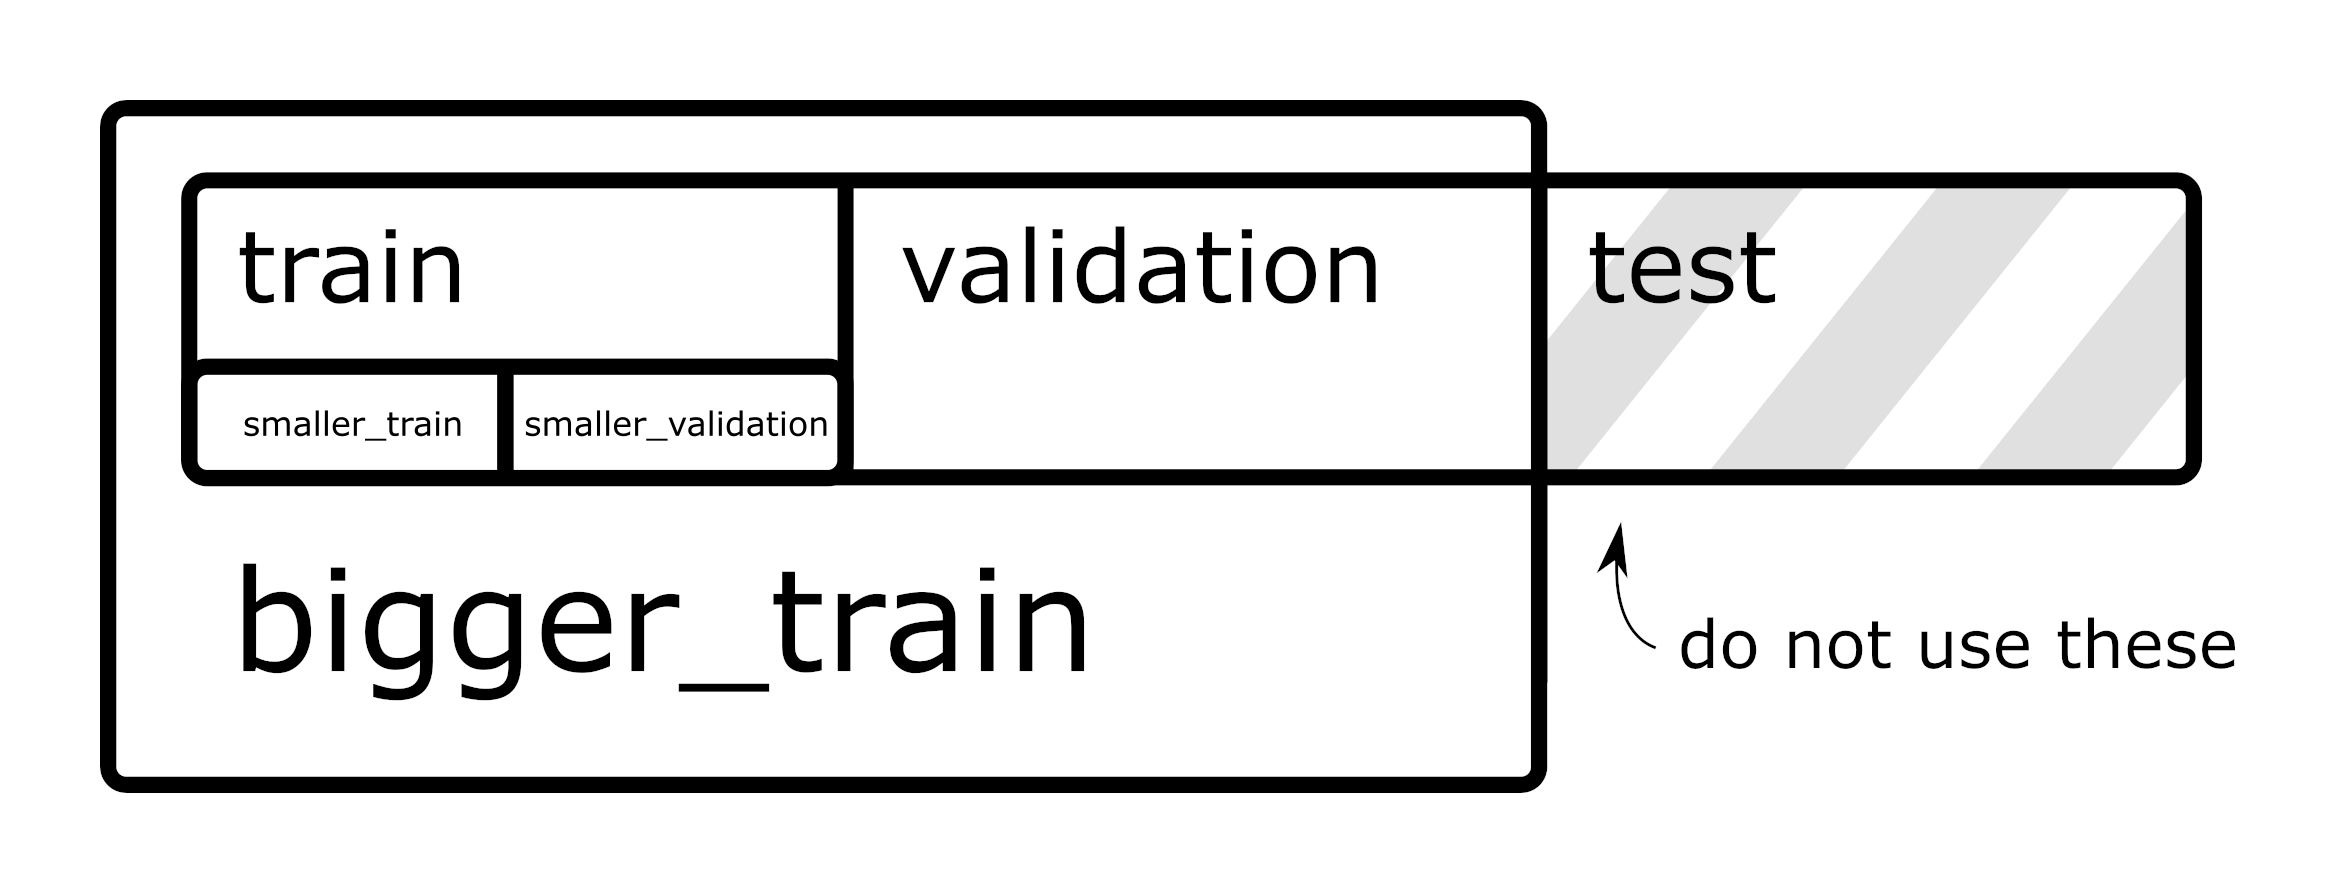

In [ ]:
from collections import OrderedDict
from itertools import chain

from pv211_utils.arqmath.loader import load_queries

smaller_train_queries = load_queries(text_format, Query, 'train', year=2020)
smaller_validation_queries = load_queries(text_format, Query, 'validation', year=2020)

train_queries = OrderedDict(chain(smaller_train_queries.items(), smaller_validation_queries.items()))
validation_queries = load_queries(text_format, Query, 'test', year=2020)

bigger_train_queries = OrderedDict(chain(train_queries.items(), validation_queries.items()))

In [ ]:
print('\n'.join(repr(query) for query in list(train_queries.values())[:3]))
print('...')
print('\n'.join(repr(query) for query in list(train_queries.values())[-3:]))

For a demonstration, we will look at query number 5. This is a query that is relatively easy to answer using just the text of the query, not the mathematical formulae. The user is asking for a computational solution to an interesting puzzle.

In [ ]:
query = train_queries[5]
query

In [ ]:
print(query.title)

In [ ]:
print(query.body)

In [ ]:
print(query.tags)

### Loading the relevance judgements
Next, we will load train and validation relevance judgements into the `train_judgements` and `validation_judgement` sets. Relevance judgements specify, which answers are relevant to which queries. You should use relevance judgements for training your supervised information retrieval system.


If you are training just a single machine learning model without any early stopping or hyperparameter optimization, you can use `bigger_train_judgements` as the input.

If you are training a single machine learning model with early stopping or hyperparameter optimization, you can use `train_judgements` for training your model and `validation_judgements` to stop early or to select the optimal hyperparameters for your model. You can then use `bigger_train_judgements` to train the model with the best number of epochs or the best hyperparameters.

If you are training many machine learning models with early stopping or hyperparameter optimization, then you can split your train judgements to smaller training and validation sets. Then, you can use `smaller_train_judgements` for training your models, `smaller_validation_judgements` to stop early or to select the optimal hyperparameters for your models, and `validation_judgements` to select the best model. You can then use `bigger_train_judgements` to train the best model with the best number of epochs or the best hyperparameters.


 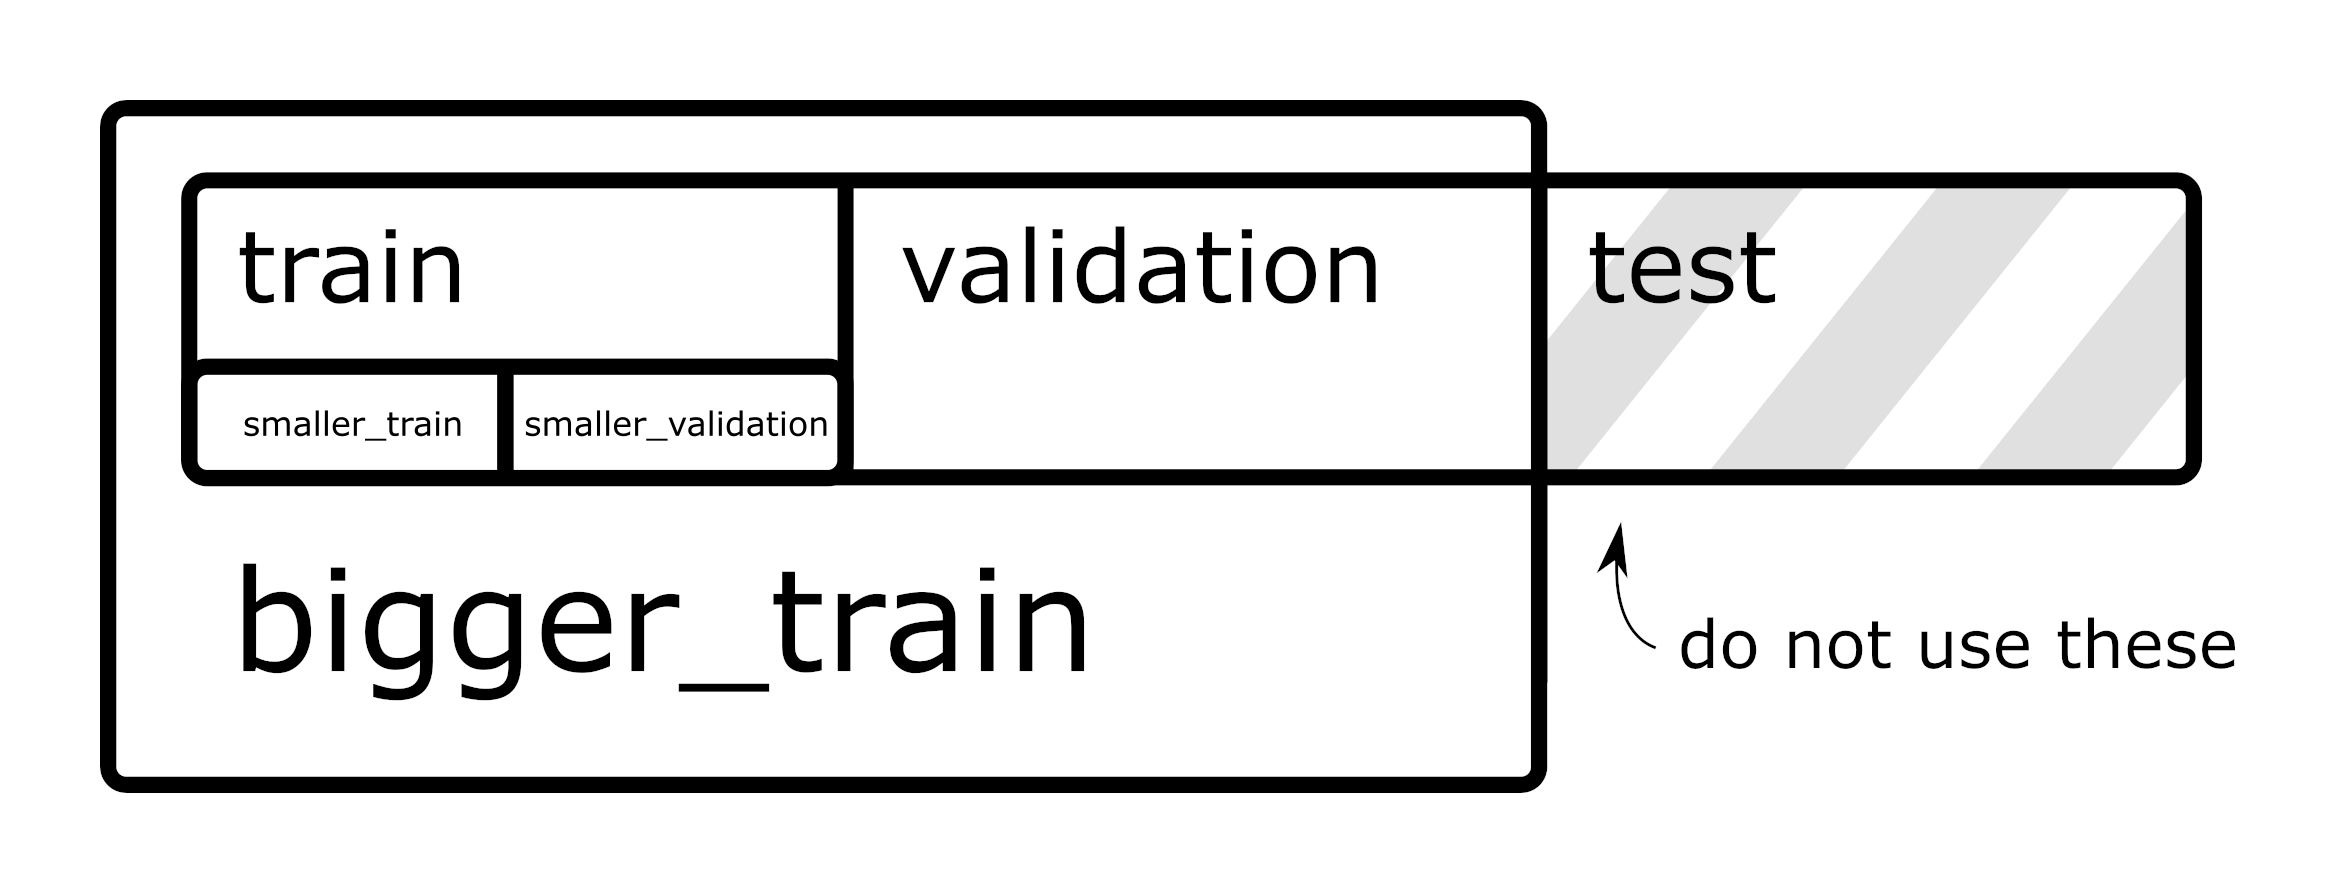

In [ ]:
from pv211_utils.arqmath.loader import load_judgements

smaller_train_judgements = load_judgements(smaller_train_queries, answers, 'train', year=2020)
smaller_validation_judgements = load_judgements(smaller_validation_queries, answers, 'validation', year=2020)

train_judgements = smaller_train_judgements | smaller_validation_judgements
validation_judgements = load_judgements(validation_queries, answers, 'test', year=2020)

bigger_train_judgements = train_judgements | validation_judgements

pivot = int(len(train_judgements) * 0.8)
smaller_train_judgements = set(sorted(train_judgements)[:pivot])
smaller_validation_judgements = set(sorted(train_judgements)[pivot:])

In [ ]:
len(bigger_train_judgements)

For a demonstration, we will look at query number 5 and show a relevant answer to the query and a non-relevant answer to the query.

In [ ]:
query = train_queries[5]
relevant_answer = answers['1037824']
irrelevant_answer = answers['432200']

In [ ]:
query

In [ ]:
relevant_answer

In [ ]:
irrelevant_answer

In [ ]:
(query, relevant_answer) in train_judgements

In [ ]:
(query, irrelevant_answer) in train_judgements

## Implementation of your information retrieval system
Next, we will define a class named `IRSystem` that will represent your information retrieval system. Your class must define a method name `search` that takes a query and returns answers in descending order of relevance to the query.

The example implementation returns answers in decreasing order of the TF-IDF cosine similarity between the answer and the query. You can use the example implementation as a basis of your system, or you can replace it with your own implementation.

In [ ]:
from multiprocessing import get_context
from typing import Iterable, Union, List, Tuple

from pv211_utils.arqmath.irsystem import ArqmathIRSystemBase

from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.utils import simple_preprocess
from tqdm import tqdm

class IRSystem(ArqmathIRSystemBase):
    """
    A system that returns answers ordered by decreasing cosine similarity.

    Attributes
    ----------
    dictionary: Dictionary
        The dictionary of the system.
    tfidf_model: TfidfModel
        The TF-IDF model of the system.
    index: MatrixSimilarity
        The indexed TF-IDF answers.
    index_to_answer: dict of (int, Answer)
        A mapping from indexed answer numbers to answers.

    """
    def __init__(self):
        with get_context('fork').Pool(None) as pool:
            answer_bodies = pool.imap(self.__class__._document_to_tokens, answers.values())
            answer_bodies = tqdm(answer_bodies, desc='Building the dictionary', total=len(answers))
            self.dictionary = Dictionary(answer_bodies)
            self.__class__.DICTIONARY = self.dictionary

        with get_context('fork').Pool(None) as pool:
            answer_vectors = pool.imap(self.__class__._document_to_bag_of_words, answers.values())
            answer_vectors = tqdm(answer_vectors, desc='Building the TF-IDF model', total=len(answers))
            self.tfidf_model = TfidfModel(answer_vectors)
            self.__class__.TFIDF_MODEL = self.tfidf_model

        with get_context('fork').Pool(None) as pool:
            answer_vectors = pool.imap(self.__class__._document_to_tfidf_vector, answers.values())
            answer_vectors = tqdm(answer_vectors, desc='Building the TF-IDF index', total=len(answers))
            self.index = SparseMatrixSimilarity(answer_vectors, num_docs=len(answers), num_terms=len(self.dictionary))
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL

        self.index_to_answer = dict(enumerate(answers.values()))

    def search(self, query: Query) -> Iterable[Answer]:
        """The ranked retrieval results for a query.

        Parameters
        ----------
        query : Query
            A query.
        
        Returns
        -------
        iterable of Document
            The ranked retrieval results for a query.

        """
        self.__class__.DICTIONARY = self.dictionary
        self.__class__.TFIDF_MODEL = self.tfidf_model

        query_vector = self.__class__._document_to_tfidf_vector(query)
        similarities = enumerate(self.index[query_vector])
        similarities = sorted(similarities, key=lambda item: item[1], reverse=True)
        for answer_number, _ in similarities:
            answer = self.index_to_answer[answer_number]
            yield answer
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL

    @classmethod
    def _document_to_tokens(cls, document: Union[Query, Answer]) -> List[str]:
        return simple_preprocess(document.body)
    
    @classmethod
    def _document_to_bag_of_words(cls, document: Union[Query, Answer]) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(cls._document_to_tokens(document))
    
    @classmethod
    def _document_to_tfidf_vector(cls, document: Union[Query, Answer]) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[cls._document_to_bag_of_words(document)]

## Evaluation
Finally, we will evaluate your information retrieval system using [the Mean Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) (MAP) evaluation measure.

In [ ]:
from pv211_utils.arqmath.leaderboard import ArqmathLeaderboard
from pv211_utils.arqmath.eval import ArqmathEvaluation

submit_result = False
author_name = 'Surname, Name'

print('Initializing your system ...')
system = IRSystem()

test_queries = load_queries(text_format, Query, year=2021)
test_judgements = load_judgements(test_queries, answers, year=2021)
evaluation = ArqmathEvaluation(system, test_judgements, ArqmathLeaderboard(), author_name, num_workers=1)
evaluation.evaluate(tqdm(test_queries.values(), desc='Querying the system'), submit_result)